# Complexity tradeoff evaluation of standard RuleFit and our version ("Simple Rulefit")

We weigh rules according to the number of rule conditions they have. Eg 'A > 1 & B > 1' weighs 2

Parameters of the evaluation:

* challenge dataset
* no feature engineering
* rules-only mode
* AUC as the performance measurement
* 5-fold cross validation

Warning: This notebook can take a few hours to run, as we train folds*max_rules_params models

Note: During the challenge, we did correct a bug in the original implementation (https://github.com/christophM/rulefit/issues/23)

In [2]:
# No feature engineering
import pandas as pd

df = pd.read_csv("heloc_dataset_v1.csv")

codes = {'Bad':1, 'Good':0}
df['RiskPerformance'] = df['RiskPerformance'].map(codes)

X, y = df.iloc[:,1:], df.iloc[:,0]

features = X.columns
X = X.as_matrix()

In [3]:
# Rules-only, no linear feature components, to evaluate only the rules' prediction power
#
# The original implementation did not work in rules-only mode, and we submitted a patch to
# their repository to correct that: https://github.com/christophM/rulefit/issues/23
# The patch has been accepted.
model_type_param = 'r'

# 5-fold cross-validation
folds = 5

# default max_rules is 2000, we sample a range of values to obtain a AUC-complexity tradeoff around 0.76 to 0.79 AUC
max_rules_params = list(range(100, 500, 50)) + list(range(500, 1500, 100)) + list(range(1500, 2501, 200)) 

In [4]:
# The RuleFit implementation sends warning about convergence, which comes from Lasso's coordinate
# descent; but we observe no influence on the quality of the model, as seen in the cross-validation scores.


import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from rulefitcustom import RuleFitCustom
import datetime


start = datetime.datetime.now()

kf = KFold(n_splits=folds)
kf.get_n_splits(X)

auc_complexity=np.empty([0, 2])
auc_complexity_simple_rules=np.empty([0, 2])

for max_rules_param in max_rules_params:
    
    auc_sum = 0
    complexity_sum = 0
    auc_sum_simple_rules = 0
    complexity_sum_simple_rules = 0

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf =              RuleFitCustom(max_rules=max_rules_param, model_type=model_type_param)
        rf_simple_rules = RuleFitCustom(max_rules=max_rules_param, model_type=model_type_param, simple_rules=True)
        
        rf.fit(X_train, y_train, feature_names=features)
        rf_simple_rules.fit(X_train, y_train, feature_names=features)

        y_predictions_test = rf.predict(X_test)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_predictions_test)
        auc_sum += metrics.auc(fpr, tpr)
        complexity_sum += rf.rules_complexity()

        y_predictions_test_simple_rules = rf_simple_rules.predict(X_test)
        fpr_simple_rules, tpr_simple_rules, _ = metrics.roc_curve(y_test, y_predictions_test_simple_rules)
        auc_sum_simple_rules += metrics.auc(fpr_simple_rules, tpr_simple_rules)
        complexity_sum_simple_rules += rf_simple_rules.rules_complexity()

    print('standard AUC {}-fold for max_rules_param {}: {}, mean complexity = {}'.format(folds, max_rules_param, auc_sum/folds, complexity_sum/folds))
    print('simple   AUC {}-fold for max_rules_param {}: {}, mean complexity = {}'.format(folds, max_rules_param, auc_sum_simple_rules/folds, complexity_sum_simple_rules/folds))
    auc_complexity = np.vstack([auc_complexity, [auc_sum/folds, complexity_sum/folds]])
    auc_complexity_simple_rules = np.vstack([auc_complexity_simple_rules, [auc_sum_simple_rules/folds, complexity_sum_simple_rules/folds]])

end =  datetime.datetime.now()

print('Evaluation time: {}'.format(end-start))


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 100: 0.7695491117170734, mean complexity = 68.2
simple   AUC 5-fold for max_rules_param 100: 0.7490136428309297, mean complexity = 55.2


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 150: 0.7728347099998123, mean complexity = 65.4
simple   AUC 5-fold for max_rules_param 150: 0.7589355924617819, mean complexity = 59.8


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 200: 0.7718926785327881, mean complexity = 103.0
simple   AUC 5-fold for max_rules_param 200: 0.7687872857717938, mean complexity = 91.8


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 250: 0.7742630690812616, mean complexity = 89.6
simple   AUC 5-fold for max_rules_param 250: 0.7700859549573964, mean complexity = 73.6


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 300: 0.7770796599156828, mean complexity = 97.0
simple   AUC 5-fold for max_rules_param 300: 0.7774274475326257, mean complexity = 84.8


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 350: 0.7817875509204464, mean complexity = 115.4
simple   AUC 5-fold for max_rules_param 350: 0.7790562926579067, mean complexity = 76.2


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 400: 0.7838501936923665, mean complexity = 123.6
simple   AUC 5-fold for max_rules_param 400: 0.7727512629401259, mean complexity = 77.8


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 450: 0.7833086421995643, mean complexity = 152.6
simple   AUC 5-fold for max_rules_param 450: 0.7798658099840587, mean complexity = 88.6


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 500: 0.7854263835706645, mean complexity = 161.8
simple   AUC 5-fold for max_rules_param 500: 0.7805426233066528, mean complexity = 83.0


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 600: 0.786727759148469, mean complexity = 160.2
simple   AUC 5-fold for max_rules_param 600: 0.7854957319858559, mean complexity = 79.0
standard AUC 5-fold for max_rules_param 700: 0.7855902578546358, mean complexity = 177.8
simple   AUC 5-fold for max_rules_param 700: 0.7817536296919888, mean complexity = 93.4


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 800: 0.7832558683964095, mean complexity = 160.4
simple   AUC 5-fold for max_rules_param 800: 0.7833926794837656, mean complexity = 107.0
standard AUC 5-fold for max_rules_param 900: 0.784626782943563, mean complexity = 166.2
simple   AUC 5-fold for max_rules_param 900: 0.7825225958319919, mean complexity = 105.2


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 1000: 0.7872777713537518, mean complexity = 162.6
simple   AUC 5-fold for max_rules_param 1000: 0.7831113365362183, mean complexity = 105.4


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 1100: 0.7864964136735274, mean complexity = 197.2
simple   AUC 5-fold for max_rules_param 1100: 0.7862164703386378, mean complexity = 119.6


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


standard AUC 5-fold for max_rules_param 1200: 0.7872433893958205, mean complexity = 182.4
simple   AUC 5-fold for max_rules_param 1200: 0.7848858239240806, mean complexity = 107.6


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 1300: 0.7867559935145552, mean complexity = 205.8
simple   AUC 5-fold for max_rules_param 1300: 0.7872065552253115, mean complexity = 106.0


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 1400: 0.7868238868917783, mean complexity = 198.8
simple   AUC 5-fold for max_rules_param 1400: 0.7881718549213854, mean complexity = 120.4


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 1500: 0.7878712985471494, mean complexity = 211.4
simple   AUC 5-fold for max_rules_param 1500: 0.7870625484398353, mean complexity = 126.2


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 1700: 0.788565038924981, mean complexity = 203.6
simple   AUC 5-fold for max_rules_param 1700: 0.7893195484419705, mean complexity = 115.6


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 1900: 0.7874255779632029, mean complexity = 226.4
simple   AUC 5-fold for max_rules_param 1900: 0.7872764261008525, mean complexity = 119.2


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 2100: 0.7881209444595569, mean complexity = 198.4
simple   AUC 5-fold for max_rules_param 2100: 0.7913534769520802, mean complexity = 127.8


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 2300: 0.788695294236821, mean complexity = 212.4
simple   AUC 5-fold for max_rules_param 2300: 0.7884079899039678, mean complexity = 132.6


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

standard AUC 5-fold for max_rules_param 2500: 0.7877229643351472, mean complexity = 230.8
simple   AUC 5-fold for max_rules_param 2500: 0.7888997879890818, mean complexity = 122.0
Evaluation time: 2:55:30.563600


In [5]:
auc_complexity

array([[  0.76954911,  68.2       ],
       [  0.77283471,  65.4       ],
       [  0.77189268, 103.        ],
       [  0.77426307,  89.6       ],
       [  0.77707966,  97.        ],
       [  0.78178755, 115.4       ],
       [  0.78385019, 123.6       ],
       [  0.78330864, 152.6       ],
       [  0.78542638, 161.8       ],
       [  0.78672776, 160.2       ],
       [  0.78559026, 177.8       ],
       [  0.78325587, 160.4       ],
       [  0.78462678, 166.2       ],
       [  0.78727777, 162.6       ],
       [  0.78649641, 197.2       ],
       [  0.78724339, 182.4       ],
       [  0.78675599, 205.8       ],
       [  0.78682389, 198.8       ],
       [  0.7878713 , 211.4       ],
       [  0.78856504, 203.6       ],
       [  0.78742558, 226.4       ],
       [  0.78812094, 198.4       ],
       [  0.78869529, 212.4       ],
       [  0.78772296, 230.8       ]])

In [6]:
auc_complexity_simple_rules

array([[  0.74901364,  55.2       ],
       [  0.75893559,  59.8       ],
       [  0.76878729,  91.8       ],
       [  0.77008595,  73.6       ],
       [  0.77742745,  84.8       ],
       [  0.77905629,  76.2       ],
       [  0.77275126,  77.8       ],
       [  0.77986581,  88.6       ],
       [  0.78054262,  83.        ],
       [  0.78549573,  79.        ],
       [  0.78175363,  93.4       ],
       [  0.78339268, 107.        ],
       [  0.7825226 , 105.2       ],
       [  0.78311134, 105.4       ],
       [  0.78621647, 119.6       ],
       [  0.78488582, 107.6       ],
       [  0.78720656, 106.        ],
       [  0.78817185, 120.4       ],
       [  0.78706255, 126.2       ],
       [  0.78931955, 115.6       ],
       [  0.78727643, 119.2       ],
       [  0.79135348, 127.8       ],
       [  0.78840799, 132.6       ],
       [  0.78889979, 122.        ]])

In [11]:
bins = [0.77, 0.78, 0.79]

# This function will filter a value if the bin was not present
def bin_auc_complexity(arr, bins):
    res = [[] for i in range(len(bins))]
    for point in arr:
        bin = round(point[0], 2)
        if bin in bins:
            res[bins.index(bin)].append(point[1])
        else:
            print('filtered point: {}'.format(point))
    return res

data_auc_complexity = bin_auc_complexity(auc_complexity, bins)
data_auc_complexity_simple_rules= bin_auc_complexity(auc_complexity_simple_rules, bins)


filtered point: [ 0.74901364 55.2       ]
filtered point: [ 0.75893559 59.8       ]


<Figure size 432x288 with 0 Axes>

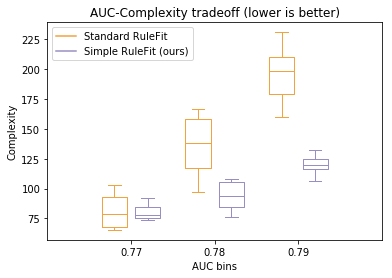

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(
    data_auc_complexity, 
    positions=np.array(range(len(data_auc_complexity)))*2.0-0.4, 
    sym='', widths=0.6)
bpr = plt.boxplot(
    data_auc_complexity_simple_rules, 
    positions=np.array(range(len(data_auc_complexity_simple_rules)))*2.0+0.4, 
    sym='', widths=0.6)
set_box_color(bpl, '#f1a340')
set_box_color(bpr, '#998ec3')

plt.plot([], c='#f1a340', label='Standard RuleFit')
plt.plot([], c='#998ec3', label='Simple RuleFit (ours)')
plt.legend()

plt.title('AUC-Complexity tradeoff (lower is better)')
plt.xticks(range(0, len(bins) * 2, 2), bins)
plt.xlim(-2, len(bins)*2)
plt.xlabel('AUC bins')
plt.ylabel('Complexity')
plt.show()

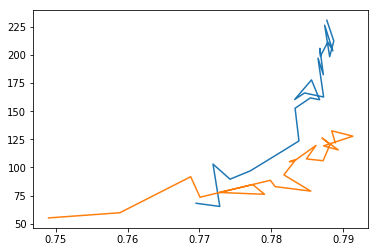

In [13]:
import matplotlib.pyplot as plt

plt.plot(auc_complexity[:,0], auc_complexity[:,1])
plt.plot(auc_complexity_simple_rules[:,0], auc_complexity_simple_rules[:,1])
plt.show()